In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from datetime import date
from plotly.offline import init_notebook_mode, iplot
import plotly.plotly as py
from plotly import tools
import string, os, random
import calendar
init_notebook_mode(connected=True)
punc = string.punctuation
from datetime import datetime
from PIL import Image
from wordcloud import WordCloud # wordcloud needs to be installed in your machine
pd.options.mode.chained_assignment = None

In [2]:
df_gun_crimes = pd.read_csv("data/gun-violence-data_01-2013_03-2018.csv")
df_gun_crimes["date"] = pd.to_datetime(df_gun_crimes["date"],format="%Y-%m-%d")
# Dropping url related columns.  Not interested...
df_gun_crimes = df_gun_crimes.drop(["incident_url","source_url","incident_url_fields_missing"],axis=1)
# Extracting year, month, day from date
df_gun_crimes["year"] = pd.DatetimeIndex(df_gun_crimes["date"]).year
df_gun_crimes["month"] = pd.DatetimeIndex(df_gun_crimes["date"]).month
df_gun_crimes["day"] = pd.DatetimeIndex(df_gun_crimes["date"]).day
df_gun_crimes["month"] = df_gun_crimes["month"].map({1:"JAN",2:"FEB",3:"MAR",4:"APR",5:"MAY",6:"JUN",7:"JUL",8:"AUG",9:"SEP",10:"OCT",11:"NOV",12:"DEC"})

In [3]:
df_gun_crimes = df_gun_crimes.rename(columns = { "n_killed":"killed","n_injured":"injured"})
df_gun_crimes = df_gun_crimes.sort_values(by = "date")

In [4]:
# READING AND CLEANING US STATES df_US_populationULATION DATA
df_US_population = pd.read_excel("data/nst-est2017-01.xlsx", header=3)
df_US_population = df_US_population[5:56]  # excluding Puerto Rico because we do not have Gun violence data for it

#df_US_population.rename(columns={0:'State name'},inplace=True)

#df_US_population[0] = df_US_population[0].apply(lambda x:x.replace(".",""))
#print(df_US_population)
#print(df_US_population[index])
#df[df.columns[2]]
df_US_population['StateName'] = df_US_population[df_US_population.columns[0]]
df_US_population['StateName'] = [i.replace(".","") for i in df_US_population['StateName'] ]

# df_US_population = df_US_population.index
df_US_population = df_US_population.rename(columns = {2010:"2010",2011:"2011",2012:"2012",2013:"2013",2014:"2014",2015:"2015",2016:"2016",2017:"2017"})
df_US_population = df_US_population.drop(["Census","Estimates Base","2010","2011","2012"],axis=1)
df_US_population["2018"] = df_US_population["2017"] # Using same as 2017.

for i in range(2013,2019,1):
    print(i)
    df_US_population[str(i)] = df_US_population[str(i)]/100000
#print(df_US_population)
#df_US_population = df_US_population/1000000 # df_US_populationulation in Millions
df_US_population = df_US_population.reset_index()
df_US_population.head()

2013
2014
2015
2016
2017
2018


,index,Unnamed: 0,2013,2014,2015,2016,2017,StateName,2018
0,5,.Alabama,48.27660,48.40037,48.50858,48.60545,48.74747,Alabama,48.74747
1,6,.Alaska,7.36760,7.36759,7.37979,7.41522,7.39795,Alaska,7.39795
2,7,.Arizona,66.16124,67.06435,68.02262,69.08642,70.16270,Arizona,70.16270
3,8,.Arkansas,29.56780,29.64800,29.75626,29.88231,30.04279,Arkansas,30.04279
4,9,.California,383.47383,387.01278,390.32444,392.96476,395.36653,California,395.36653


In [6]:
state_kill   = df_gun_crimes.groupby("state")["killed"].sum().reset_index().sort_values(by="killed",ascending=False)
state_injury = df_gun_crimes.groupby("state")["injured"].sum().reset_index().sort_values(by="injured",ascending=False)
# from df_US_population df, calculating average df_US_populationulation for each state
df_US_population["df_US_populationST_avg"] = np.mean(df_US_population,axis=1)
df_US_population_ST = df_US_population[["StateName","df_US_populationST_avg"]]
df_US_population_ST = df_US_population_ST.rename(columns={"StateName":"state"})
# calculating killed per million people, and sorting descending for plot
#state_affected = df_gun_crimes.groupby("state")["killed"].sum().reset_index().sort_values(by="killed",ascending=False) + df_gun_crimes.groupby("state")["injured"].sum().reset_index().sort_values(by="injured",ascending=False)
state_kill = df_gun_crimes.groupby("state")["killed"].sum().reset_index().sort_values(by="killed",ascending=False)
state_kill_pM = pd.merge(state_kill, df_US_population_ST, on="state")
#print(state_kill_pM)
#state_kill_pM["killed_per_Million"] = state_kill_pM["killed"]/state_kill_pM["df_US_populationST_avg"]
state_kill_pM["killed_per_Million"] = state_kill_pM["killed"]
state_kill_pM = state_kill_pM.drop(["killed","df_US_populationST_avg"],axis=1)
state_kill_pM = state_kill_pM.reset_index().sort_values(by="killed_per_Million",ascending=False).round(decimals=1)
# calculating injured per million people, and sorting descending for plot
state_injury = df_gun_crimes.groupby("state")["injured"].sum().reset_index().sort_values(by="injured",ascending=False)
state_injury_pM = pd.merge(state_injury, df_US_population_ST, on="state")
#state_injury_pM["injured_per_Million"] = state_injury_pM["injured"]/state_injury_pM["df_US_populationST_avg"]
state_injury_pM["injured_per_Million"] = state_injury_pM["injured"]
state_injury_pM = state_injury_pM.drop(["injured","df_US_populationST_avg"],axis=1)
state_injury_pM = state_injury_pM.reset_index().sort_values(by="injured_per_Million",ascending=False).round(decimals=1)
#state_affected

In [7]:
# LOADING GUN LAWS DATA AND MERGING WITH KILL PER MILLION DATA FOR COMPARISON
xls = pd.ExcelFile("data/TL-283_State Firearm Law Database_v1.3.xlsx")
df_gun_laws_r = pd.read_excel(xls, "Restrictive", header=3) # Created a table in xls "Restrictive" worksheet of all restrictive laws by state
df_gun_laws_r = df_gun_laws_r.rename(columns={"Row Labels":"state","Count of Effect":"# of Restrictive Laws"})
df_gun_laws = pd.merge(state_kill_pM, df_gun_laws_r, on="state")
df_gun_laws_p = pd.read_excel(xls, "Permissive", header=3) # Created a table in xls "Permissive" worksheet of all permissive laws by state
df_gun_laws_p = df_gun_laws_p.rename(columns={"Row Labels":"state","Count of Effect":"# of Permissive Laws"})
df_gun_laws = pd.merge(df_gun_laws, df_gun_laws_p, on="state")
df_gun_laws = df_gun_laws.rename(columns={"state":"STATE","Count of Effect":"# of Permissive Laws"})
df_gun_laws = df_gun_laws.drop(["index"],axis=1)
df_gun_laws.head()

,STATE,killed_per_Million,# of Restrictive Laws,# of Permissive Laws
0,California,5562,27,2
1,Texas,5046,3,5
2,Florida,3909,8,3
3,Illinois,3409,12,3
4,Ohio,2508,5,2


In [8]:
#df_gun_laws_2 = df_gun_laws.copy(deep=True)
#df_gun_laws_2.drop(df_gun_laws_2.tail(39).index,inplace=True)
#df_gun_laws_2
#df_gun_laws_2.rename(columns={"killed_per_Million": "People_Killed"})

,STATE,People_Killed,# of Restrictive Laws,# of Permissive Laws
0,California,5562,27,2
1,Texas,5046,3,5
2,Florida,3909,8,3
3,Illinois,3409,12,3
4,Ohio,2508,5,2
5,Georgia,2456,8,6
6,Pennsylvania,2395,10,7
7,North Carolina,2225,9,2
8,Louisiana,2179,3,6
9,Missouri,2136,8,5


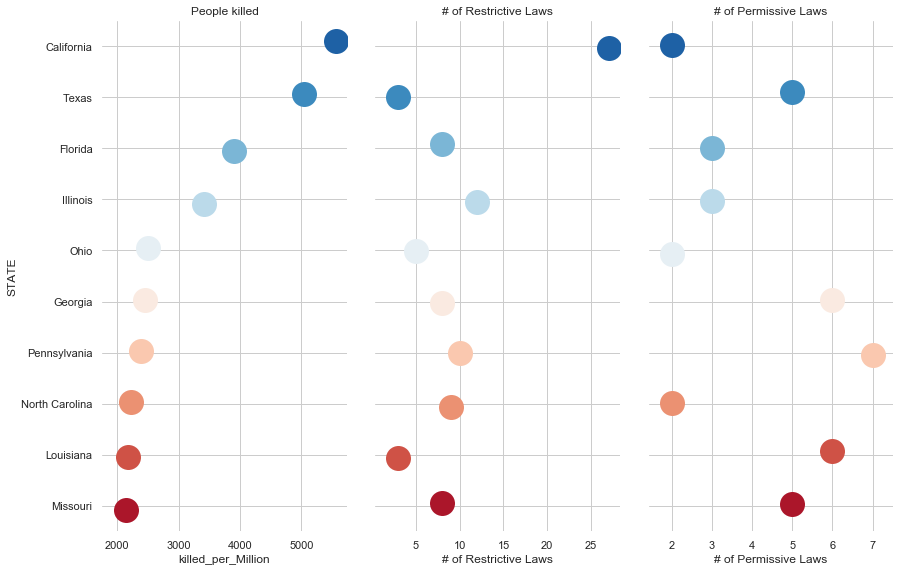

In [18]:
# PLOTTING killed PER MILLION, # OF RESTRICTIVE LAWS AND # OF PERMISSIVE LAWS SIDE BY SIDE
sns.set_context('talk')
sns.set(style="whitegrid")
# Makeing a PairGrid
g = sns.PairGrid(df_gun_laws_2,
                 x_vars=df_gun_laws.columns[1:4], y_vars=["STATE"],
                 size=8,aspect=0.5)
# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=25, orient="h",
      palette="RdBu_r", edgecolor="gray")

fig = g.fig
fig.savefig('Plots/lawsvspeople.png', dpi=300, bbox_inches='tight')
#sns.saveplot("Plots/lawsvspeople.png")
# Giving titles to each graph
titles = ["People killed", "# of Restrictive Laws", "# of Permissive Laws"]
for ax, title in zip(g.axes.flat, titles):
    # Seting a different title for each axes
    ax.set(title=title)
    # Turning grids on
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
# Removing main axes, leaving grids
sns.despine(left=True, bottom=True) 

In [11]:
df_opiate_od = pd.read_csv("data/overdoses.csv")
df_opiate_od.head() 

df_opiate_od.rename(columns={'State':'state'},inplace=True) # Renaming the State variable to merge with gun violence dataset
df_opiate_od.info()

df_gun_crimes['incident_year'] = pd.to_datetime(df_gun_crimes['date'])
df_gun_crimes['incident_year'] = df_gun_crimes['incident_year'].dt.year

df_states = df_gun_crimes[df_gun_crimes['incident_year'] == 2014]['state'].value_counts()
statesdf = pd.DataFrame()
statesdf['state'] = df_states.index
statesdf['counts'] = df_states.values
statesdf = pd.merge(statesdf,df_opiate_od, on='state')
statesdf['Population']=statesdf['Population']/1000000 # 2014 df_US_population in Millions
statesdf['counts']=statesdf['counts']/statesdf['Population']
statesdf['Deaths']=statesdf['Deaths']/statesdf['Population']


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
state         50 non-null object
Population    50 non-null int64
Deaths        50 non-null int64
Abbrev        50 non-null object
dtypes: int64(2), object(2)
memory usage: 1.6+ KB


In [12]:
data = [
    {
        'x': statesdf['Deaths'],
        'y': statesdf['counts'],
        'mode': 'markers',
        'text' : statesdf['Abbrev'],
        'marker': {
            'color': ["#bebada","#fdb462","#fb8072","#d9d9d9","#bc80bd","#b3de69","#8dd3c7","#80b1d3","#fccde5",
                      "#ffffb3","#bebada","#fdb462","#fb8072","#d9d9d9","#bc80bd","#b3de69","#8dd3c7","#80b1d3",
                      "#fccde5","#ffffb3","#bebada","#fdb462","#fb8072","#d9d9d9","#bc80bd","#b3de69","#8dd3c7",
                      "#80b1d3","#fccde5","#ffffb3","#bebada","#fdb462","#fb8072","#d9d9d9","#bc80bd","#b3de69",
                      "#8dd3c7","#80b1d3","#fccde5","#ffffb3","#bebada","#fdb462","#fb8072","#d9d9d9","#bc80bd",
                      "#b3de69","#8dd3c7","#80b1d3","#fccde5","#ffffb3"],
            'size': 15,
            'showscale' : False,
            'colorscale' : 'Earth',
            'opacity': 0.8
        }
    }
]

layout = go.Layout(title="Overdose Deaths Vs Gun Violence Incidents by State (2014)", 
                   xaxis=dict(title='Total Overdose Deaths Per Million People'),
                   yaxis=dict(title='Gun Violence Incidents Per Million People')
                  )
fig = go.Figure(data = data, layout = layout)
iplot(fig, filename='scatter-colorscale')

In [ ]:
df_drug_data = pd.read_csv("data/CDC_drug_data.csv")
